# **Data Science - Machine Learning - Soil Content**

### Leif Holmquist

#### 1. Find issues in data
#### 2. Compare Soil Organic Matter (SOM) content of soil device to POLARIS soil database
        * Specifically compare the 2 fields (A and B) to the POLARIS data
#### 3. Create 2 predictive models of the SOM
        * Evaluate performance

## 1. Find issues in the data

In [ ]:
# Import Python libraries
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
print("Setup Complete")

Setup Complete


In [ ]:
# Check working directory location
print(os.getcwd())

C:\Users\Leffe


In [ ]:
# Load dataframe
geods_path = 'Desktop/challenge/stenon_challenge_geoDS.csv'
geods_data = pd.read_csv(geods_path, sep=';', index_col='measurement_ID')
geods_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073 entries, 0 to 1072
Columns: 292 entries, lat_lng to nir_2522
dtypes: float64(290), object(2)
memory usage: 2.4+ MB


In [ ]:
geods_data.head()

,lat_lng,location,som,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,"(41.2799111,-92.0301512)",field_A,2.038524,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,...,0.122705,0.121610,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820
1,"(41.2798524,-92.0294544)",field_A,17.443334,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,...,0.165669,0.164012,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674
2,"(41.2798545,-92.0294499)",field_A,2.227260,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,...,0.140496,0.138907,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550
3,"(41.2796759,-92.027938)",field_A,2.369437,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,...,0.197408,0.195094,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768
4,"(41.2796802,-92.027932)",field_A,2.345968,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,...,0.173269,0.171223,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455


In [ ]:
# Check for missing values
missing_vals = (geods_data.isnull().sum())
print(missing_vals[missing_vals > 0])

som         2
nir_1382    1
nir_1390    1
nir_1430    1
nir_1442    1
nir_1454    1
nir_1530    1
nir_1538    1
nir_1554    1
nir_1602    1
nir_1634    1
nir_1710    1
nir_1718    1
nir_1986    1
nir_2018    1
nir_2126    1
nir_2202    1
nir_2362    1
nir_2414    1
nir_2454    1
nir_2494    1
dtype: int64


In [ ]:
# Check for incorrect coords
count = 0
for row in geods_data['lat_lng']:
    if row == "(0,0)": 
        count += 1
        print(count)

1


**There is locational data that is geographically incorrect, this needs to be removed for any further meaningful analysis.**

In [ ]:
# Create Latitude and Longitude columns
lat = []
lng = []
for row in geods_data['lat_lng']:
    try:
        if row == '(0,0)':
            lat.append(np.nan)
            lng.append(np.nan)
        else:
            lat.append(float(row[1:].split(',')[0]))
            lng.append(float(row[:-1].split(',')[1]))
    except:
        # append a missing value to lat
        lat.append(np.nan)
        # append a missing value to lon
        lng.append(np.nan)
        
geods_latlong_data = geods_data.copy()
        
geods_latlong_data['latitude'] = lat
geods_latlong_data['longitude'] = lng
geods_latlong_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073 entries, 0 to 1072
Columns: 294 entries, lat_lng to longitude
dtypes: float64(292), object(2)
memory usage: 2.4+ MB


In [ ]:
geods_latlong_data.head()

,lat_lng,location,som,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,"(41.2799111,-92.0301512)",field_A,2.038524,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,...,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820,41.279911,-92.030151
1,"(41.2798524,-92.0294544)",field_A,17.443334,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,...,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674,41.279852,-92.029454
2,"(41.2798545,-92.0294499)",field_A,2.227260,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,...,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550,41.279854,-92.029450
3,"(41.2796759,-92.027938)",field_A,2.369437,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,...,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768,41.279676,-92.027938
4,"(41.2796802,-92.027932)",field_A,2.345968,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,...,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455,41.279680,-92.027932


In [ ]:
# Check coord nulls
geods_latlong_data.latitude.isnull().value_counts()

False    1072
True        1
Name: latitude, dtype: int64

In [ ]:
# Drop null coord data
geods_latlong_data = geods_latlong_data.drop(geods_latlong_data[(geods_latlong_data.latitude.isnull())].index)
print(geods_latlong_data.latitude.isnull().value_counts())

False    1072
Name: latitude, dtype: int64


In [ ]:
# Detect outliers
def detect_outlier(data_col):
    outliers = []
    
    threshold = 3
    mean_col = np.mean(data_col)
    std_col = np.std(data_col)
    
    for row in data_col:
        z_score = (row - mean_col)/std_col 
        if np.abs(z_score) > threshold:
            print("Outliers: ", row)
            outliers.append(np.nan)
        else: 
            outliers.append(row)
    return outliers

In [ ]:
geods_latlong_data.loc[:,'som'] = detect_outlier(geods_latlong_data['som'])

Outliers:  17.4433343112995
Outliers:  9.10039267674331


In [ ]:
# Check for missing values again
missing_vals = (geods_latlong_data.isnull().sum())
print(missing_vals[missing_vals > 0])

som         4
nir_1382    1
nir_1390    1
nir_1430    1
nir_1442    1
nir_1454    1
nir_1530    1
nir_1538    1
nir_1554    1
nir_1602    1
nir_1634    1
nir_1710    1
nir_1718    1
nir_1986    1
nir_2018    1
nir_2126    1
nir_2202    1
nir_2362    1
nir_2414    1
nir_2454    1
nir_2494    1
dtype: int64


In [ ]:
geods_latlong_data.head()

,lat_lng,location,som,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,"(41.2799111,-92.0301512)",field_A,2.038524,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,...,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820,41.279911,-92.030151
1,"(41.2798524,-92.0294544)",field_A,NaN,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,...,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674,41.279852,-92.029454
2,"(41.2798545,-92.0294499)",field_A,2.227260,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,...,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550,41.279854,-92.029450
3,"(41.2796759,-92.027938)",field_A,2.369437,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,...,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768,41.279676,-92.027938
4,"(41.2796802,-92.027932)",field_A,2.345968,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,...,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455,41.279680,-92.027932


**There are some missing values for the spectroscopic measurements and SOM. These values will be removed or imputed in the modelling stage.**

## 2. Compare Soil Organic Matter (SOM) content of Farmlab device to POLARIS soil database

In [ ]:
# Export data to csv 
geods_latlong_data.to_csv('Desktop/challenge/geods_latlong.csv', index_label='measurement_ID', index=True)

### Polaris geotiffs downloaded
* OM band (Log10 of %)
* 0-5 cm
* 5-15 cm
* 15-30 cm

### Imported into GIS software tool*

*Would have preferred doing these steps in Rasterio Python library to streamline the process but was unable to get the library compatible with the Python environment

#### 1. GeoDS dataset to XY Points
#### 2. Import Polaris geotiffs
#### 3. Convert Polaris OM from Log10 to Base %
    * Raster Calculator
        * 10^(OM Band)
#### 4. Inspection on Bands with GeoDS
    * 15-30 appears to lack OM, so would throw off comparison
    * 0-5 and 5-15 within the GeoDS ranges
#### 5. Create Polaris OM Mean raster from depths 0 to 15 cm
    * Raster Calculator
        * (OM_0_5 + OM_05_15) / 2
#### 6. Sample Mean Raster with GeoDS point locations (Mean SOM points)
#### 7. Join Mean SOM points to GeoDS point table
#### 8. Export Point table to CSV

### Import in Python environment for comparison

In [ ]:
# Import CSV with added polaris SOM column
geods_polaris_path = 'Desktop/challenge/geods_polaris.csv'
geods_polaris_data = pd.read_csv(geods_polaris_path, sep=',', index_col='measurement_ID')
geods_polaris_data.head()

,lat_lng,location,som,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,...,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude,som_remote
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,"(41.2799111,-92.0301512)",field_A,2.038524,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,...,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820,41.279911,-92.030151,1.547664
1,"(41.2798524,-92.0294544)",field_A,0.000000,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,...,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674,41.279852,-92.029454,1.549498
2,"(41.2798545,-92.0294499)",field_A,2.227260,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,...,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550,41.279854,-92.029450,1.549498
3,"(41.2796759,-92.027938)",field_A,2.369437,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,...,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768,41.279676,-92.027938,2.015490
4,"(41.2796802,-92.027932)",field_A,2.345968,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,...,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455,41.279680,-92.027932,2.015490


In [ ]:
# Check for zeros (GIS software changed nulls to zero by default)
missing_vals = (geods_polaris_data == 0).sum()
print(missing_vals[missing_vals > 0])

som         4
nir_1382    1
nir_1390    1
nir_1430    1
nir_1442    1
nir_1454    1
nir_1530    1
nir_1538    1
nir_1554    1
nir_1602    1
nir_1634    1
nir_1710    1
nir_1718    1
nir_1986    1
nir_2018    1
nir_2126    1
nir_2202    1
nir_2362    1
nir_2414    1
nir_2454    1
nir_2494    1
dtype: int64


In [ ]:
# Replace zeroes with NaN
geods_polaris_data = geods_polaris_data.replace(0, np.nan)       

In [ ]:
# Check for zeroes removed
missing_vals = (geods_polaris_data == 0).sum()
print(missing_vals[missing_vals > 0])

Series([], dtype: int64)


In [ ]:
# Group by Field location and save basic statistical data
data_comp = geods_polaris_data.groupby('location').describe()

In [ ]:
print(data_comp['som'])

          count      mean       std       min       25%       50%       75%  \
location                                                                      
field_A   677.0  2.186232  0.332492  1.186776  1.957470  2.179737  2.390757   
field_B   391.0  2.248767  0.716121  1.146822  1.724791  1.973801  2.682996   

               max  
location            
field_A   3.225132  
field_B   4.260811  


In [ ]:
print(data_comp['som_remote'])

          count      mean       std       min       25%       50%       75%  \
location                                                                      
field_A   679.0  1.916817  0.230622  1.471182  1.750613  1.945309  2.051562   
field_B   393.0  1.674229  0.393148  1.469336  1.514752  1.548419  1.645372   

               max  
location            
field_A   3.061458  
field_B   3.684422  


**Basic look at the stats shows similar values but with obvious differences.
<br>
Lower values in the Polaris data compared to the FarmLab device. Though with higher min value than the device.**

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

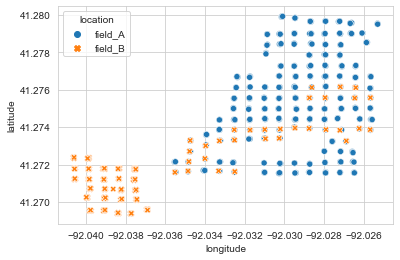

In [ ]:
# View Field A and B geographical location
sns.set_style("whitegrid")
sns.scatterplot(data=geods_polaris_data, x="longitude", y="latitude", hue="location", style="location")

***Note: Field A appears to be in one general large location and Field B appears to be in a smaller location but also some values within the geographical area of Field A, not sure if this is a data collection error or as intended but will assume it is as intended in the comparison.**

In [ ]:
# Create seperate dataframes for Field A and Field B to compare against the Polaris data
geods_field_a = geods_polaris_data[(geods_polaris_data.location == 'field_A')].copy()
geods_field_b = geods_polaris_data[(geods_polaris_data.location == 'field_B')].copy()

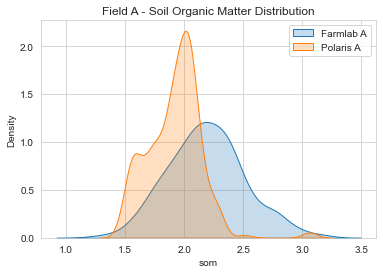

In [ ]:
# Field A distribution plot
sns.kdeplot(data=geods_field_a['som'], label='Farmlab A', shade=True)
sns.kdeplot(data=geods_field_a['som_remote'],  label='Polaris A', shade=True)

plt.title("Field A - Soil Organic Matter Distribution")
plt.legend()

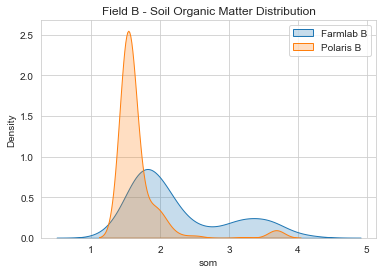

In [ ]:
# Field B distribution plot
sns.kdeplot(data=geods_field_b['som'], label='Farmlab B', shade=True)
sns.kdeplot(data=geods_field_b['som_remote'],  label='Polaris B', shade=True)

plt.title("Field B - Soil Organic Matter Distribution")
plt.legend()

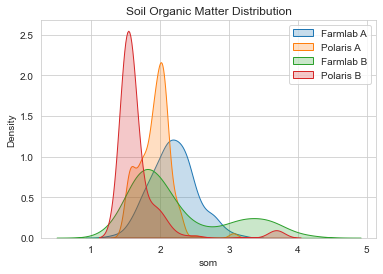

In [ ]:
# Distribution for both fields
sns.kdeplot(data=geods_field_a['som'], label='Farmlab A', shade=True)
sns.kdeplot(data=geods_field_a['som_remote'],  label='Polaris A', shade=True)
sns.kdeplot(data=geods_field_b['som'], label='Farmlab B', shade=True)
sns.kdeplot(data=geods_field_b['som_remote'],  label='Polaris B', shade=True)

plt.title("Soil Organic Matter Distribution")
plt.legend()

**The distribution plots more clearly show the differences between the Farmlab and Polaris data.
<br>
With the distribution of values of the Polaris data being more dense on the mode, this is most likely partly due to the low resolution of the Polaris data when plotted to these higher resolution point samples.
<br>
This probably accounts for why the samples have a broader distribution as they more accurately represent the local variaion in values that the 30x30 meter Polaris data is averaged out for.**

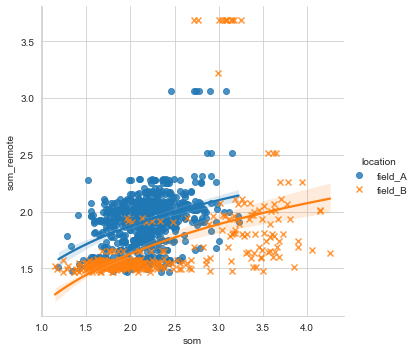

In [ ]:
# Plot linear regression of fields
sns.lmplot(data=geods_polaris_data, x="som", y="som_remote", hue="location", markers=["o", "x"], logx=True)

**The linear regression plot shows a positive correlation between Farmlab SOM and Polaris SOM_REMOTE.
<br>
Which is as should be expected that if there is an increase in reported Farmlab SOM value it should increase in the Polaris SOM reported values.**

#### Below is just some further comparison, uncomment to view

In [ ]:
np.mean(geods_polaris_data['nir_1374'])

0.44482049125559714

<AxesSubplot:xlabel='location', ylabel='nir_1370'>

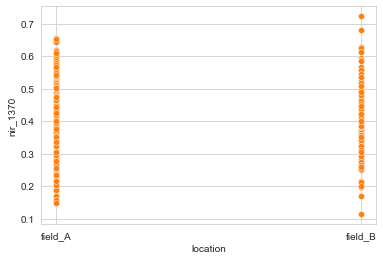

In [ ]:
#sns.scatterplot(data=geods_polaris_data, y="nir_1370", x="location")
#sns.scatterplot(data=geods_polaris_data, y="nir_1370", x="location")

In [ ]:
#sns.swarmplot(x=geods_polaris_data['location'], y=geods_polaris_data['som'])

In [ ]:
#sns.swarmplot(x=geods_polaris_data['location'], y=geods_polaris_data['som_remote'])

In [ ]:
#sns.jointplot(x=geods_field_b['som'], y=geods_field_b['som_remote'], kind="kde")

In [ ]:
#sns.jointplot(x=geods_field_a['som'], y=geods_field_a['som_remote'], kind="kde")

## 3. Create 2 predictive models of the SOM

### Model 1 - Random Forest

In [ ]:
# Set variable to be predicted (replace NaN values with median value)
y = geods_polaris_data.som
y.fillna(y.median(), inplace=True)
y.head()

measurement_ID
0    2.038524
1    2.126274
2    2.227260
3    2.369437
4    2.345968
Name: som, dtype: float64

In [ ]:
# Drop variables to not be used for prediction
X = geods_polaris_data.drop(['som', 'lat_lng', 'som_remote'], axis=1)
X.head()

,location,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,field_A,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,...,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820,41.279911,-92.030151
1,field_A,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,0.346260,0.331784,...,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674,41.279852,-92.029454
2,field_A,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,...,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550,41.279854,-92.029450
3,field_A,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,...,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768,41.279676,-92.027938
4,field_A,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,...,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455,41.279680,-92.027932


In [ ]:
# Divide the data into training and validation sets
X_train_pre, X_valid_pre, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [ ]:
# Select categorical columns
categorical_cols = [cname for cname in X_train_pre.columns if X_train_pre[cname].nunique() < 5 and X_train_pre[cname].dtype == "object"]
print(categorical_cols)

['location']


In [ ]:
# Select numerical columns
numerical_cols = [cname for cname in X_train_pre.columns if X_train_pre[cname].dtype in ['int64', 'float64']]
#print(numerical_cols)

In [ ]:
# Categorical and numerical columns to use as predictors
final_cols2 = categorical_cols + numerical_cols
X_train = X_train_pre[final_cols2].copy()
X_valid = X_valid_pre[final_cols2].copy()
X_valid.head()

,location,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
948,field_B,0.501294,0.498685,0.494036,0.486535,0.475860,0.462648,0.447651,0.431331,0.414011,...,0.205383,0.203861,0.202594,0.201583,0.200828,0.200331,0.200092,0.200113,41.271598,-92.035521
267,field_A,0.487327,0.484026,0.478613,0.470202,0.458700,0.444505,0.428052,0.410003,0.391960,...,0.187816,0.186046,0.184533,0.183309,0.182408,0.181865,0.181713,0.181987,41.271588,-92.028761
440,field_A,0.380649,0.377582,0.372613,0.365395,0.356043,0.344804,0.332169,0.318843,0.305810,...,0.169780,0.168781,0.167936,0.167247,0.166714,0.166341,0.166128,0.166076,41.277861,-92.027212
589,field_A,0.439600,0.436685,0.431776,0.424176,0.414090,0.401984,0.388256,0.373236,0.357667,...,0.168206,0.166527,0.164998,0.163653,0.162528,0.161661,0.161088,0.160840,41.274452,-92.030985
426,field_A,0.542870,0.540224,0.535280,0.527148,0.516033,0.502480,0.487098,0.470549,0.453832,...,0.235523,0.233858,0.232437,0.231270,0.230366,0.229735,0.229387,0.229330,41.278997,-92.027975


In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# Find best amount of leaf nodes for the Random Forest
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
    my_pipeline.fit(X_train, y_train)
    preds = my_pipeline.predict(X_valid)
    mae = mean_absolute_error(y_valid, preds)
    return(mae)

In [ ]:
# Find best max leaf node within a range
candidate_max_leaf_nodes = [50, 100, 150, 200, 250, 300, 350, 500, 550, 600, 650, 700]
scores = {leaf_size: get_mae(leaf_size, X_train, X_valid, y_train, y_valid) for leaf_size in candidate_max_leaf_nodes}
best_tree_size = min(scores, key=scores.get)
print(scores)
print(best_tree_size)

{50: 0.23526910873306334, 100: 0.23058923839883994, 150: 0.22981549512499613, 200: 0.22935859665742087, 250: 0.22892468684865244, 300: 0.22871370426497586, 350: 0.2287382139755968, 500: 0.22859051622169316, 550: 0.2285911968888456, 600: 0.22859128606446502, 650: 0.22859128606446502, 700: 0.22859128606446502}
500


In [ ]:
# Random Forest Model (categorical and location data intact)
start = time.time()
model = RandomForestRegressor(max_leaf_nodes=best_tree_size, random_state=0)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
end = time.time()
print('MAE of the Random Forest Model (500 leaf nodes):', score)
print ("Random Forest Model (500 leaf nodes) took:", end - start, " seconds.")
print('\n', preds)

MAE of the Random Forest Model (500 leaf nodes): 0.22859051622169316
Random Forest Model (500 leaf nodes) took: 9.869593143463135  seconds.

 [2.81127564 2.24142685 2.02128217 1.85200176 2.22770083 2.63116923
 1.81790291 1.800885   2.02590302 2.00424503 2.02243868 2.46876979
 2.1155338  2.23250193 1.95882949 2.03006903 2.1163123  2.26378315
 2.38553048 2.18225122 2.19901348 2.45318271 2.23918737 2.5004383
 1.85722025 2.4362811  1.96940326 2.09695919 2.1154609  1.89763047
 2.32703181 2.01086955 1.81596676 2.11944185 2.14000285 1.79206361
 2.17287703 2.24391652 1.92102047 2.17021809 2.39587803 2.19580929
 2.06237495 1.89915268 2.39105373 2.17444144 2.11936527 2.20846193
 3.49740289 2.18307166 2.51041904 2.48777063 2.16728261 2.27863627
 2.43660873 2.25506756 2.25095414 2.57993191 2.38833775 2.05350581
 1.78285624 2.30917117 1.95336212 2.04182671 1.81977755 2.25017509
 3.39985635 3.4745157  2.00743377 2.37972228 2.38981646 2.39049322
 2.23672008 1.9415703  2.92933805 2.46740373 1.78986214

In [ ]:
# Random Tree Cross-Validation Model
start = time.time()
model = RandomForestRegressor(max_leaf_nodes=best_tree_size, random_state=0)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', model)])
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (cross-validations):")
print(scores.mean())
end = time.time()
print ("Cross-Validation of this Random Forest model took:", end - start, " seconds.")

MAE scores:
 [0.25782562 0.269576   0.34115419 0.2811603  0.27085092]
Average MAE score (cross-validations):
0.28411340615141556
Cross-Validation of this Random Forest model took: 49.69060778617859  seconds.


In [ ]:
# Drop categorical variables to not be used for prediction
X2 = geods_polaris_data.drop(['som', 'lat_lng', 'location','som_remote', 'latitude', 'longitude'], axis=1)
X2.head()

,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,0.210194,...,0.122705,0.121610,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820
1,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,0.346260,0.331784,0.318220,...,0.165669,0.164012,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674
2,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,0.306737,...,0.140496,0.138907,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550
3,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,0.399946,...,0.197408,0.195094,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768
4,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,0.368113,...,0.173269,0.171223,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455


In [ ]:
# Divide the data into training and validation sets
X_train_pre2, X_valid_pre2, y_train2, y_valid2 = train_test_split(X2, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [ ]:
# Select categorical columns
categorical_cols2 = [cname for cname in X_train_pre2.columns if X_train_pre2[cname].nunique() < 5 and X_train_pre2[cname].dtype == "object"]
print(categorical_cols2)

[]


In [ ]:
# Select numerical columns
numerical_cols2 = [cname for cname in X_train_pre2.columns if X_train_pre2[cname].dtype in ['int64', 'float64']]
#print(numerical_cols2)

In [ ]:
# Categorical and numerical columns to use as predictors
final_cols2 = categorical_cols2 + numerical_cols2
X_train2 = X_train_pre2[final_cols2].copy()
X_valid2 = X_valid_pre2[final_cols2].copy()
X_valid2.head()

,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
measurement_ID,,,,,,,,,,,,,,,,,,,,,
948,0.501294,0.498685,0.494036,0.486535,0.475860,0.462648,0.447651,0.431331,0.414011,0.396902,...,0.209183,0.207159,0.205383,0.203861,0.202594,0.201583,0.200828,0.200331,0.200092,0.200113
267,0.487327,0.484026,0.478613,0.470202,0.458700,0.444505,0.428052,0.410003,0.391960,0.375855,...,0.191988,0.189808,0.187816,0.186046,0.184533,0.183309,0.182408,0.181865,0.181713,0.181987
440,0.380649,0.377582,0.372613,0.365395,0.356043,0.344804,0.332169,0.318843,0.305810,0.294568,...,0.172232,0.170931,0.169780,0.168781,0.167936,0.167247,0.166714,0.166341,0.166128,0.166076
589,0.439600,0.436685,0.431776,0.424176,0.414090,0.401984,0.388256,0.373236,0.357667,0.343269,...,0.171865,0.169997,0.168206,0.166527,0.164998,0.163653,0.162528,0.161661,0.161088,0.160840
426,0.542870,0.540224,0.535280,0.527148,0.516033,0.502480,0.487098,0.470549,0.453832,0.438682,...,0.239546,0.237422,0.235523,0.233858,0.232437,0.231270,0.230366,0.229735,0.229387,0.229330


In [ ]:
# Find best amount of leaf nodes for the Random Forest
def get_mae2(max_leaf_nodes, train_X, val_X, train_y, val_y):
    numerical_transformer2 = SimpleImputer(strategy='median')
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    my_pipeline = Pipeline(steps=[('preprocessor', numerical_transformer2),('model', model)])
    my_pipeline.fit(X_train2, y_train2)
    preds = my_pipeline.predict(X_valid2)
    mae = mean_absolute_error(y_valid2, preds)
    return(mae)

In [ ]:
# Find best max leaf node within a range
candidate_max_leaf_nodes2 = [50, 100, 150, 200, 250, 300, 350, 500, 550, 600, 650, 700]
scores2 = {leaf_size: get_mae2(leaf_size, X_train2, X_valid2, y_train2, y_valid2) for leaf_size in candidate_max_leaf_nodes2}
best_tree_size2 = min(scores2, key=scores2.get)
print(scores2)
print(best_tree_size2)

{50: 0.3332616820837414, 100: 0.33193179897217917, 150: 0.33032609602841156, 200: 0.3300936072956826, 250: 0.3305718861555302, 300: 0.3307110275671116, 350: 0.3306397371905061, 500: 0.33063143468214823, 550: 0.3306282487007465, 600: 0.33062835760997666, 650: 0.33062835760997666, 700: 0.33062835760997666}
200


In [ ]:
# Random Forest Model (categorical and location data removed)
start = time.time()
numerical_transformer2 = SimpleImputer(strategy='median')
model = RandomForestRegressor(max_leaf_nodes=best_tree_size2, random_state=0)
my_pipeline = Pipeline(steps=[('preprocessor', numerical_transformer2),('model', model)])
my_pipeline.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid2)

# Evaluate the model
score = mean_absolute_error(y_valid2, preds)
end = time.time()
print('MAE of the Random Forest Model (200 leaf nodes) (location, lat, long data removed):', score)
print ("Random Forest Model (200 leaf nodes) took:", end - start, " seconds.")
print('\n', preds)

MAE of the Random Forest Model (200 leaf nodes) (location, lat, long data removed): 0.3300936072956826
Random Forest Model (200 leaf nodes) took: 11.84769892692566  seconds.

 [2.20037324 2.21242286 2.07046842 2.12544257 2.10723599 2.09840827
 2.0213614  1.98043995 2.02011213 2.00884547 2.04692018 2.17722504
 2.19064285 2.32267665 2.45616192 2.18894165 2.11985678 2.1920533
 2.20418908 2.37197391 2.17458904 2.56414821 2.09674266 2.18088992
 1.91166037 2.59961912 2.06493148 1.98352977 2.3972333  2.31162526
 2.28028289 2.03421672 2.02609468 2.15698334 1.93358005 2.00821746
 2.50621329 2.37542096 2.10999683 2.44503343 2.03967575 1.99325506
 2.17482216 2.47851438 2.23658248 2.47428003 2.23362677 2.14986481
 2.35096622 2.3457314  2.35873008 2.19972503 2.55504042 2.42747253
 2.3880651  2.14727398 2.64478644 2.29455989 2.24003943 2.03014571
 1.91287668 2.21047664 2.12953775 2.32331717 2.02693128 2.16503841
 2.3069536  2.49374161 2.22122209 2.17334322 2.16898778 2.38088337
 2.22054766 2.3297702

In [ ]:
# Random Tree Cross-Validation Model
start = time.time()
model = RandomForestRegressor(max_leaf_nodes=100, random_state=0)
my_pipeline = Pipeline(steps=[('preprocessor', numerical_transformer2),('model', model)])
scores = -1 * cross_val_score(my_pipeline, X2, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (cross-validations):")
print(scores.mean())
end = time.time()
print ("Cross-Validation of this Random Forest model took:", end - start, " seconds.")

MAE scores:
 [0.28823823 0.25919388 0.37337287 0.41460666 0.66426841]
Average MAE score (cross-validations):
0.3999360093398188
Cross-Validation of this Random Forest model took: 50.97856307029724  seconds.


**The best random forest model had an MAE of 0.2289 and cross-validation MAE score of 0.2841.
<br>
This was the RF Model with 500 leaf nodes and the categorical and latitude and longitude data intact as predictors.**

### Model 2 - Gradient Boosting

In [ ]:
# Set variable to be predicted (replace NaN values with median value)
y = geods_polaris_data.som
y.fillna(y.median(), inplace=True)
y.head()

measurement_ID
0    2.038524
1    2.126274
2    2.227260
3    2.369437
4    2.345968
Name: som, dtype: float64

In [ ]:
# Drop variables to not be used for prediction
X = geods_polaris_data.drop(['som', 'lat_lng', 'som_remote'], axis=1)
X.head()

,location,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,field_A,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,...,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820,41.279911,-92.030151
1,field_A,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,0.346260,0.331784,...,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674,41.279852,-92.029454
2,field_A,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,...,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550,41.279854,-92.029450
3,field_A,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,...,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768,41.279676,-92.027938
4,field_A,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,...,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455,41.279680,-92.027932


In [ ]:
# Divide the data into training and validation sets
X_train_pre, X_valid_pre, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [ ]:
# Select categorical columns
categorical_cols = [cname for cname in X_train_pre.columns if X_train_pre[cname].nunique() < 5 and X_train_pre[cname].dtype == "object"]
print(categorical_cols)

['location']


In [ ]:
# Select numerical columns
numerical_cols = [cname for cname in X_train_pre.columns if X_train_pre[cname].dtype in ['int64', 'float64']]
#print(numerical_cols)

In [ ]:
# Categorical and numerical columns to use as predictors
final_cols = categorical_cols + numerical_cols
X_train = X_train_pre[final_cols].copy()
X_valid = X_valid_pre[final_cols].copy()
X_valid.head()

,location,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,...,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522,latitude,longitude
measurement_ID,,,,,,,,,,,,,,,,,,,,,
948,field_B,0.501294,0.498685,0.494036,0.486535,0.475860,0.462648,0.447651,0.431331,0.414011,...,0.205383,0.203861,0.202594,0.201583,0.200828,0.200331,0.200092,0.200113,41.271598,-92.035521
267,field_A,0.487327,0.484026,0.478613,0.470202,0.458700,0.444505,0.428052,0.410003,0.391960,...,0.187816,0.186046,0.184533,0.183309,0.182408,0.181865,0.181713,0.181987,41.271588,-92.028761
440,field_A,0.380649,0.377582,0.372613,0.365395,0.356043,0.344804,0.332169,0.318843,0.305810,...,0.169780,0.168781,0.167936,0.167247,0.166714,0.166341,0.166128,0.166076,41.277861,-92.027212
589,field_A,0.439600,0.436685,0.431776,0.424176,0.414090,0.401984,0.388256,0.373236,0.357667,...,0.168206,0.166527,0.164998,0.163653,0.162528,0.161661,0.161088,0.160840,41.274452,-92.030985
426,field_A,0.542870,0.540224,0.535280,0.527148,0.516033,0.502480,0.487098,0.470549,0.453832,...,0.235523,0.233858,0.232437,0.231270,0.230366,0.229735,0.229387,0.229330,41.278997,-92.027975


In [ ]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
# XGBoost Model (categorical and location data intact)
start = time.time()
my_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', my_model)])
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
end = time.time()
print('MAE of the XGBoost Model (location, lat, long data intact):', score)
print ("This XGBoost Model took:", end - start, " seconds.")
print('\n', preds)

MAE of the XGBoost Model (location, lat, long data intact): 0.2298515686336965
This XGBoost Model took: 13.996551513671875  seconds.

 [2.7803004 2.2987964 1.9737616 1.8363556 2.211225  2.4625895 1.9017545
 1.8958523 1.9268627 2.0621014 2.0361989 2.7077842 2.1058931 2.08274
 2.2041607 1.9809784 2.1734645 2.3251553 2.355063  2.2873447 2.1004426
 2.4680178 2.08504   2.5691845 1.8582598 2.4681704 1.8664997 1.9898665
 2.2223306 2.1550522 2.342685  2.1500514 1.7946285 2.0282938 2.3096626
 1.767799  2.0623128 2.2752354 1.9164412 2.1112387 2.2220974 2.2158785
 2.0016346 2.0893939 2.3944755 2.361709  2.0728736 2.2393007 3.608869
 2.2800846 2.699587  2.6267247 2.1780736 2.215049  2.5779264 2.3615458
 2.213645  2.6246212 2.324889  2.0041015 1.9195455 2.3967102 2.0160112
 2.1174374 1.8480219 2.3771808 3.4599557 3.607976  2.0621219 2.2648864
 2.3513784 2.51334   2.2464855 1.8586985 3.1077719 2.4480164 1.6802831
 2.2460356 1.9938895 2.2875295 2.24713   2.3249137 2.107153  1.7638589
 2.419873  1.855

In [ ]:
# Perform XGBoost with similar predictors
start = time.time()
my_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('model', my_model)])
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (cross-validations):")
print(scores.mean())
end = time.time()
print ("Cross-Validation of this Random Forest model took:", end - start, " seconds.")

MAE scores:
 [0.26828342 0.26480767 0.33252647 0.28180271 0.29873012]
Average MAE score (cross-validations):
0.28923008132132016
Cross-Validation of this Random Forest model took: 70.31938457489014  seconds.


In [ ]:
# Drop categorical variables to not be used for prediction
X2 = geods_polaris_data.drop(['som', 'lat_lng', 'location','som_remote', 'latitude', 'longitude'], axis=1)
X2.head()

,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
measurement_ID,,,,,,,,,,,,,,,,,,,,,
0,0.268311,0.266145,0.262247,0.256983,0.250741,0.243620,0.235660,0.226879,0.218042,0.210194,...,0.122705,0.121610,0.120648,0.119822,0.119134,0.118585,0.118178,0.117913,0.117794,0.117820
1,0.411358,0.407535,0.401783,0.393936,0.384204,0.372926,0.360293,0.346260,0.331784,0.318220,...,0.165669,0.164012,0.162577,0.161365,0.160374,0.159602,0.159048,0.158710,0.158586,0.158674
2,0.402013,0.398604,0.393279,0.385631,0.375653,0.363615,0.349929,0.335372,0.320722,0.306737,...,0.140496,0.138907,0.137509,0.136309,0.135311,0.134522,0.133946,0.133589,0.133455,0.133550
3,0.506582,0.503565,0.498138,0.489784,0.478757,0.465691,0.450905,0.434083,0.416469,0.399946,...,0.197408,0.195094,0.193042,0.191262,0.189763,0.188553,0.187640,0.187033,0.186739,0.186768
4,0.475707,0.472190,0.466343,0.457769,0.446611,0.433262,0.418009,0.401053,0.383799,0.368113,...,0.173269,0.171223,0.169431,0.167901,0.166637,0.165644,0.164924,0.164483,0.164326,0.164455


In [ ]:
# Divide the data into training and validation sets
X_train_pre2, X_valid_pre2, y_train2, y_valid2 = train_test_split(X2, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [ ]:
# Select categorical columns
categorical_cols2 = [cname for cname in X_train_pre2.columns if X_train_pre2[cname].nunique() < 5 and X_train_pre2[cname].dtype == "object"]
print(categorical_cols2)

[]


In [ ]:
# Select numerical columns
numerical_cols2 = [cname for cname in X_train_pre2.columns if X_train_pre2[cname].dtype in ['int64', 'float64']]
#print(numerical_cols2)

In [ ]:
# Categorical and numerical columns to use as predictors
final_cols2 = categorical_cols2 + numerical_cols2
X_train2 = X_train_pre2[final_cols2].copy()
X_valid2 = X_valid_pre2[final_cols2].copy()
X_valid2.head()

,nir_1370,nir_1374,nir_1378,nir_1382,nir_1386,nir_1390,nir_1394,nir_1398,nir_1402,nir_1406,...,nir_2486,nir_2490,nir_2494,nir_2498,nir_2502,nir_2506,nir_2510,nir_2514,nir_2518,nir_2522
measurement_ID,,,,,,,,,,,,,,,,,,,,,
948,0.501294,0.498685,0.494036,0.486535,0.475860,0.462648,0.447651,0.431331,0.414011,0.396902,...,0.209183,0.207159,0.205383,0.203861,0.202594,0.201583,0.200828,0.200331,0.200092,0.200113
267,0.487327,0.484026,0.478613,0.470202,0.458700,0.444505,0.428052,0.410003,0.391960,0.375855,...,0.191988,0.189808,0.187816,0.186046,0.184533,0.183309,0.182408,0.181865,0.181713,0.181987
440,0.380649,0.377582,0.372613,0.365395,0.356043,0.344804,0.332169,0.318843,0.305810,0.294568,...,0.172232,0.170931,0.169780,0.168781,0.167936,0.167247,0.166714,0.166341,0.166128,0.166076
589,0.439600,0.436685,0.431776,0.424176,0.414090,0.401984,0.388256,0.373236,0.357667,0.343269,...,0.171865,0.169997,0.168206,0.166527,0.164998,0.163653,0.162528,0.161661,0.161088,0.160840
426,0.542870,0.540224,0.535280,0.527148,0.516033,0.502480,0.487098,0.470549,0.453832,0.438682,...,0.239546,0.237422,0.235523,0.233858,0.232437,0.231270,0.230366,0.229735,0.229387,0.229330


In [ ]:
# Random Forest Model (categorical and location data removed)
start = time.time()
numerical_transformer2 = SimpleImputer(strategy='median')

my_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
my_pipeline = Pipeline(steps=[('preprocessor', numerical_transformer2),('model', my_model)])
my_pipeline.fit(X_train2, y_train2)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid2)

# Evaluate the model
score = mean_absolute_error(y_valid2, preds)
end = time.time()
print('MAE of the XGBoost Model (location, lat, long data removed):', score)
print ("XGBoost Model took:", end - start, " seconds.")
print('\n', preds)

MAE of the XGBoost Model (location, lat, long data removed): 0.35071754129789107
XGBoost Model took: 13.852936267852783  seconds.

 [2.3720906 2.2101698 1.9498768 2.026295  2.1677    2.1583176 2.019456
 1.8423986 2.0305145 1.9625542 2.1073983 2.2089415 2.2785053 2.3070583
 2.5896351 2.2201452 2.0967453 2.1587746 2.4460006 2.9637752 2.0924628
 2.4176598 2.0575676 2.0607605 1.9423202 2.5070364 1.9878763 1.8952879
 2.8122835 2.620814  2.27083   1.9385971 1.9055488 2.102143  1.8081138
 1.930928  2.73007   2.6269252 2.1337845 2.5113533 1.8379056 1.8109866
 2.0952854 2.6286533 2.49135   2.5130093 2.1677005 2.363149  2.7392282
 2.449734  2.3762586 2.5636528 2.52018   2.3780646 2.3701012 2.1072953
 2.5217254 2.2277446 2.2648578 2.25969   1.9074515 2.2105618 2.1153054
 2.4669974 1.9692508 2.1404965 2.4086273 2.2581992 2.3378997 1.8877449
 2.3183725 2.1517038 1.9811839 2.1968997 2.3667355 2.6056504 2.0057907
 1.9676971 2.250118  2.1406164 2.2015433 2.1709387 2.124225  2.1412303
 2.2545798 1.9261

In [ ]:
# Perform XGBoost with categorical and location data removed
start = time.time()
my_model = XGBRegressor(n_estimators=500, learning_rate=0.05)
my_pipeline = Pipeline(steps=[('preprocessor', numerical_transformer2),('model', my_model)])
scores = -1 * cross_val_score(my_pipeline, X2, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)
print("Average MAE score (cross-validations):")
print(scores.mean())
end = time.time()
print ("Cross-Validation of this Random Forest model took:", end - start, " seconds.")

MAE scores:
 [0.33874324 0.2888749  0.39418648 0.42661713 0.67843215]
Average MAE score (cross-validations):
0.4253707800506312
Cross-Validation of this Random Forest model took: 70.10046124458313  seconds.


**The best Gradient Boosting model had an MAE of 0.2299 with cross-validation MAE score of 0.2892.
<br>
This model kept the categorical data (location) and the latitude and longitude data intact.
<br>
Though the first Gradient Boosting model was very close, neither gradient boosting model outperformed the Random Forest Model (0.2289 and 0.2841).
<br>
The Random Forest Model had a faster runtime of 4 seconds quicker to process.**